In [1]:
#Data Preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2

In [2]:
#Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [5]:
from numpy.random import seed
seed(0)

In [6]:
tf.random.set_seed(0)

In [7]:
path = './COVID-19_Radiography_Dataset/'

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get)

In [8]:
# covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()

In [9]:
# covidData.columns = ['image_id', 'path']

In [10]:
# classes = covidData.image_id.str.split('-').str[0]

In [11]:
# covidData['diag'] = classes
# covidData['target'] = covidData['diag'].map(diag_code_dict.get)
# covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [12]:
# covidData[covidData.isnull()]

In [13]:
samples,feature = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Simple EDA')
print('Number of samples: %d'%(samples))
print('duplicates: %d'%(duplicated))
print('null values: %d' %(null_values))

Simple EDA
Number of samples: 21165
duplicates: 0
null values: 0


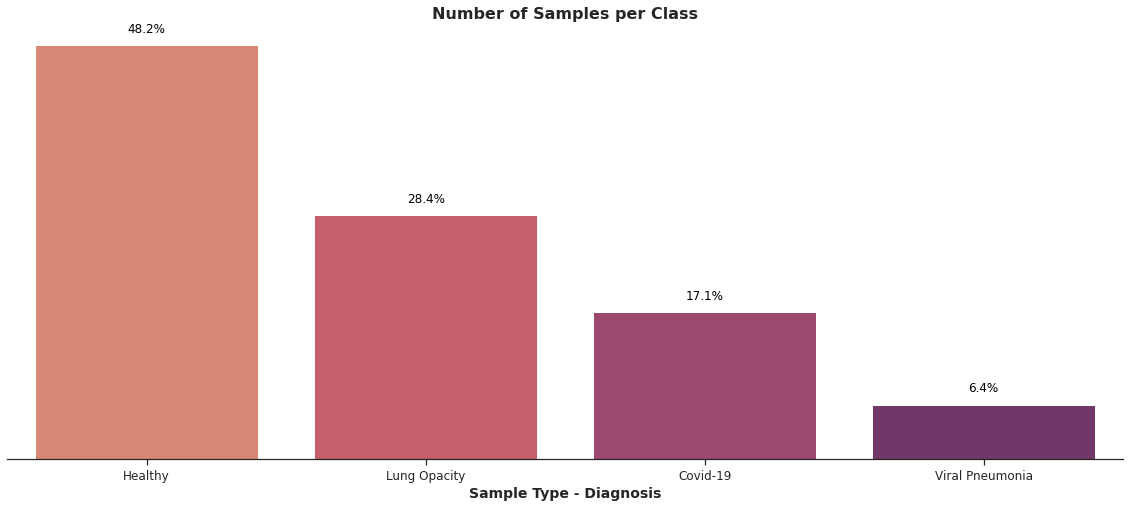

In [14]:
#samples per class
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 16,weight = 'bold');
#plot percentage
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [15]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75, 75))))

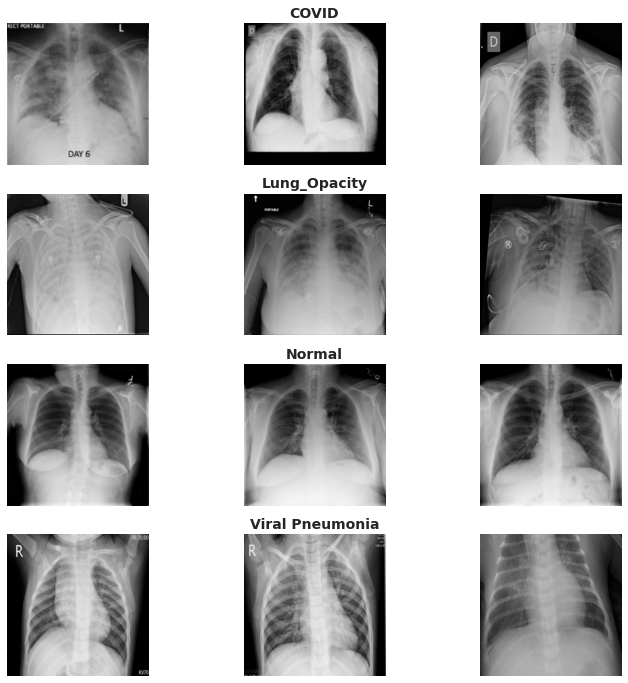

In [16]:
n_samples =3

fig, m_axs = plt.subplots(4, n_samples, figsize = (4*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs,covidData.sort_values(['diag']).groupby('diag')):
    n_axs[1].set_title(type_name,fontsize = 14,weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')

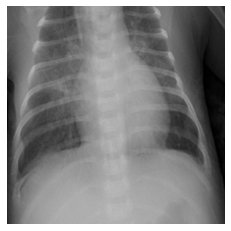

In [17]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image - cv2.imread(picture)
plt.imshow(image)
plt.axis('off')
plt.show()

In [18]:
print('shape of the image: {}'.format(image.shape))

shape of the image: (299, 299, 3)


In [19]:
print('image size {}'.format(image.size))

image size 268203


In [20]:
image.dtype

dtype('uint8')

In [21]:
print('max rgb: {}'.format(image.max()))

max rgb: 189


In [22]:
print('min rgb: {}'.format(image.min()))

min rgb: 0


In [23]:
image[0, 0]

array([86, 86, 86], dtype=uint8)

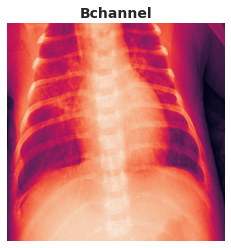

In [24]:
plt.title('Bchannel', fontsize=14, weight='bold')
plt.imshow(image[:,:,0])
plt.axis('off');
plt.show()

In [25]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:, ['image', 'Class', 'path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

Text(0.5, 1.0, 'Image color mean value distribution')

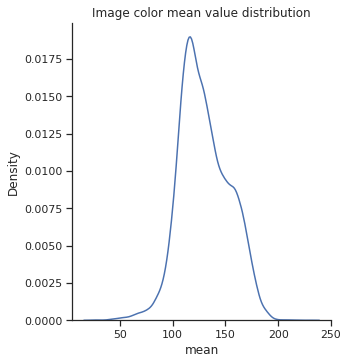

In [26]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde")
plt.title('Image color mean value distribution')

Text(0.5, 1.0, 'Image color mean value distribution by class')

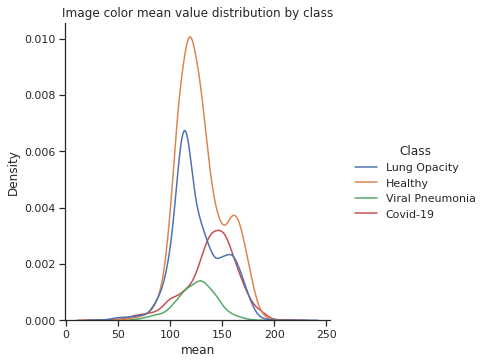

In [27]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue='Class')
plt.title('Image color mean value distribution by class')

Text(0.5, 1.0, 'Image color max value distribution by class')

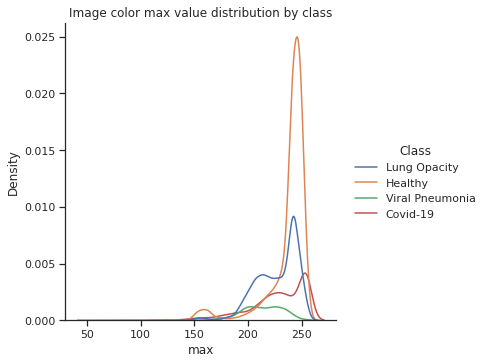

In [28]:
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue='Class')
plt.title('Image color max value distribution by class')

Text(0.5, 1.0, 'Image color min value distribution by class')

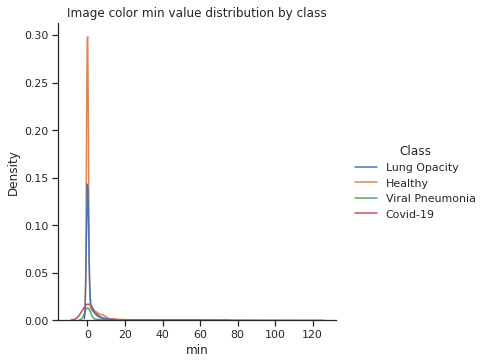

In [29]:
sns.displot(data = imageEDA, x = 'min', kind="kde", hue='Class')
plt.title('Image color min value distribution by class')

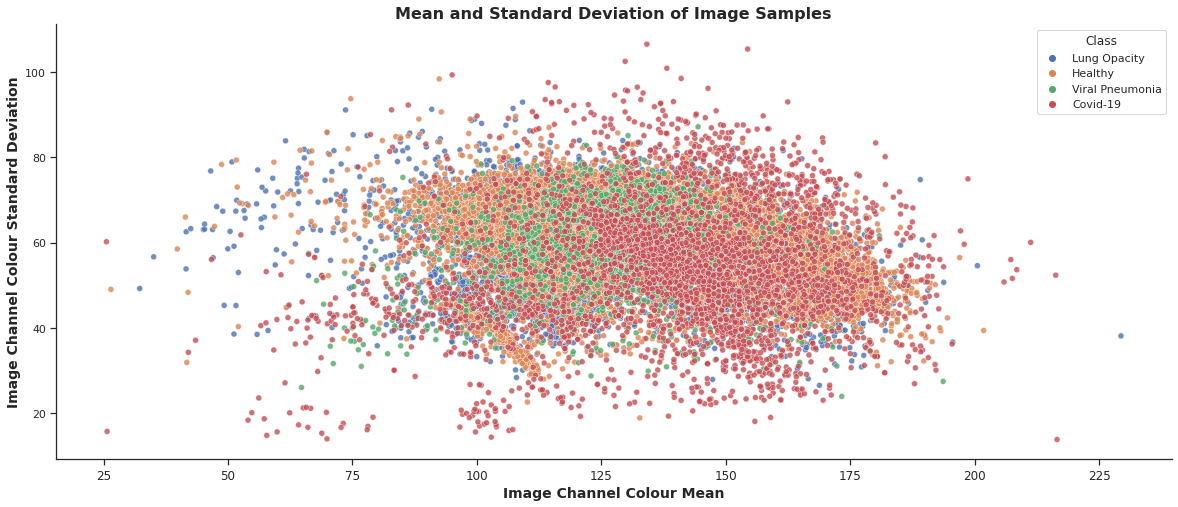

In [30]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');

<Figure size 1440x576 with 0 Axes>

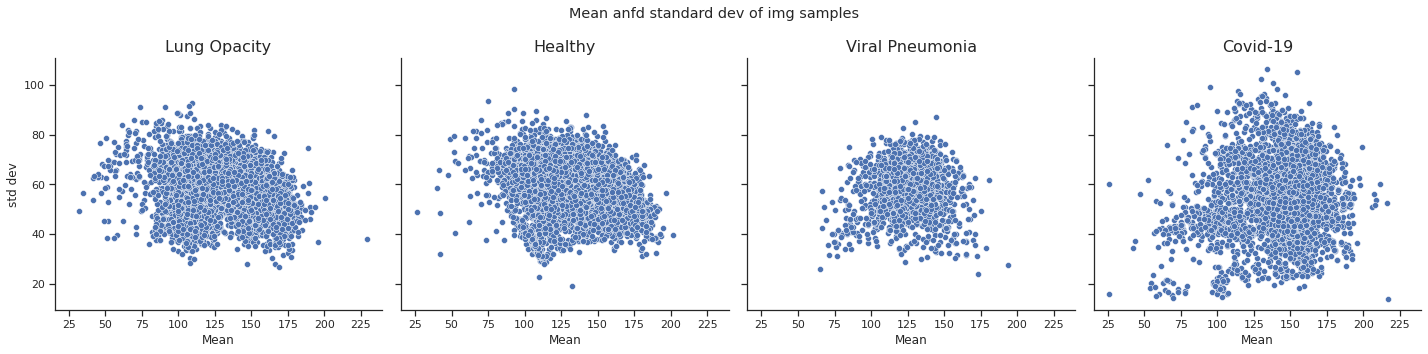

In [31]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="Class", height=5)
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=16)
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Mean anfd standard dev of img samples')
axes = g.axes.flatten()
axes[0].set_ylabel('std dev')
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

# Model

In [32]:
path = './COVID-19_Radiography_Dataset/'

classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory=path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")

test_gen = test_datagen.flow_from_directory(directory=path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [33]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='Same', input_shape=(299, 299, 1)))
model.add(BatchNormalization())

################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 299, 299, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 64)      256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 149, 149, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      3

In [37]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

In [38]:
#Model params
epochs=300

#callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_loss', mode='min')

callbacks_list = [learning_rate_reduction, early_stopping_monitor]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs, callbacks=[callbacks_list])

Epoch 1/300
66/66 [==============================] - 17s 173ms/step - loss: 1.5533 - recall_1: 0.3741 - val_loss: 1.7430 - val_recall_1: 0.0000e+00
Epoch 2/300
66/66 [==============================] - 11s 164ms/step - loss: 1.2419 - recall_1: 0.4337 - val_loss: 1.2195 - val_recall_1: 0.0586
Epoch 3/300
66/66 [==============================] - 11s 160ms/step - loss: 1.1783 - recall_1: 0.4441 - val_loss: 1.0031 - val_recall_1: 0.1680
Epoch 4/300
66/66 [==============================] - 11s 160ms/step - loss: 1.1483 - recall_1: 0.4508 - val_loss: 1.2801 - val_recall_1: 0.0703
Epoch 5/300
66/66 [==============================] - 11s 160ms/step - loss: 1.0966 - recall_1: 0.4896 - val_loss: 0.5632 - val_recall_1: 0.7695
Epoch 6/300
66/66 [==============================] - 11s 160ms/step - loss: 1.0776 - recall_1: 0.4716 - val_loss: 0.9464 - val_recall_1: 0.2812
Epoch 7/300
66/66 [==============================] - 11s 159ms/step - loss: 1.0461 - recall_1: 0.5043 - val_loss: 1.0956 - val_recal

66/66 [==============================] - 10s 156ms/step - loss: 0.9739 - recall_1: 0.5407 - val_loss: 1.4417 - val_recall_1: 0.1719
Epoch 58/300
66/66 [==============================] - 10s 158ms/step - loss: 0.9891 - recall_1: 0.5455 - val_loss: 1.4241 - val_recall_1: 0.1797
Epoch 59/300
66/66 [==============================] - 10s 156ms/step - loss: 0.9624 - recall_1: 0.5312 - val_loss: 1.4125 - val_recall_1: 0.1797
Epoch 60/300
66/66 [==============================] - 11s 160ms/step - loss: 1.0018 - recall_1: 0.5180 - val_loss: 1.4388 - val_recall_1: 0.1719
Epoch 61/300
66/66 [==============================] - 11s 162ms/step - loss: 0.9708 - recall_1: 0.5350 - val_loss: 1.4222 - val_recall_1: 0.1836
Epoch 62/300
66/66 [==============================] - 11s 159ms/step - loss: 1.0231 - recall_1: 0.5170 - val_loss: 1.4339 - val_recall_1: 0.1797
Epoch 63/300
66/66 [==============================] - 11s 159ms/step - loss: 1.0140 - recall_1: 0.5199 - val_loss: 1.4344 - val_recall_1: 0.175

In [39]:
y_pred = model.predict(test_gen)

In [45]:
history.history

{'loss': [1.5533244609832764,
  1.241922378540039,
  1.1783314943313599,
  1.1483283042907715,
  1.0965980291366577,
  1.0776327848434448,
  1.0460673570632935,
  1.0831130743026733,
  1.07234525680542,
  1.0488275289535522,
  1.0646958351135254,
  1.0441240072250366,
  1.0386383533477783,
  0.9976109862327576,
  1.0144859552383423,
  1.035447120666504,
  0.9984546899795532,
  0.9823499917984009,
  1.0225610733032227,
  1.038322925567627,
  0.9576845169067383,
  1.0164439678192139,
  0.9958271980285645,
  0.9381973147392273,
  1.026462435722351,
  0.9269404411315918,
  0.9728917479515076,
  0.9623176455497742,
  0.9973508715629578,
  0.9896071553230286,
  0.9719746708869934,
  0.9520856738090515,
  0.9261026978492737,
  0.9825007319450378,
  0.9691631197929382,
  0.9588832259178162,
  0.920802652835846,
  0.9850380420684814,
  0.9649838805198669,
  0.891629159450531,
  0.9892870783805847,
  0.9378746151924133,
  1.0114794969558716,
  0.8834887742996216,
  0.9699614644050598,
  1.002411

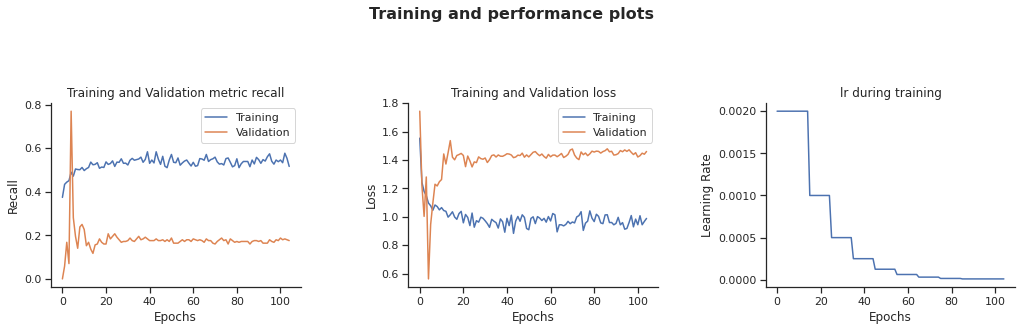

In [48]:
fig, axarr = plt.subplots(1,3, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['recall_1'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_recall_1'], ax=axarr[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = history.history['lr'], ax=axarr[2]);
ax.set_ylabel('Learning Rate')

axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')
axarr[2].set_title('lr during training')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

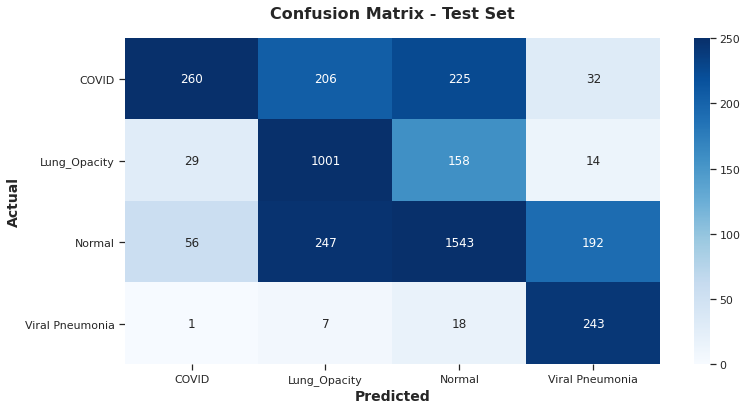

In [49]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

**Overall Results**
Accuracy Result: 72.00%
Precision Result: 68.39%
Recall Result: 71.32%
F-Score Result: 66.53%


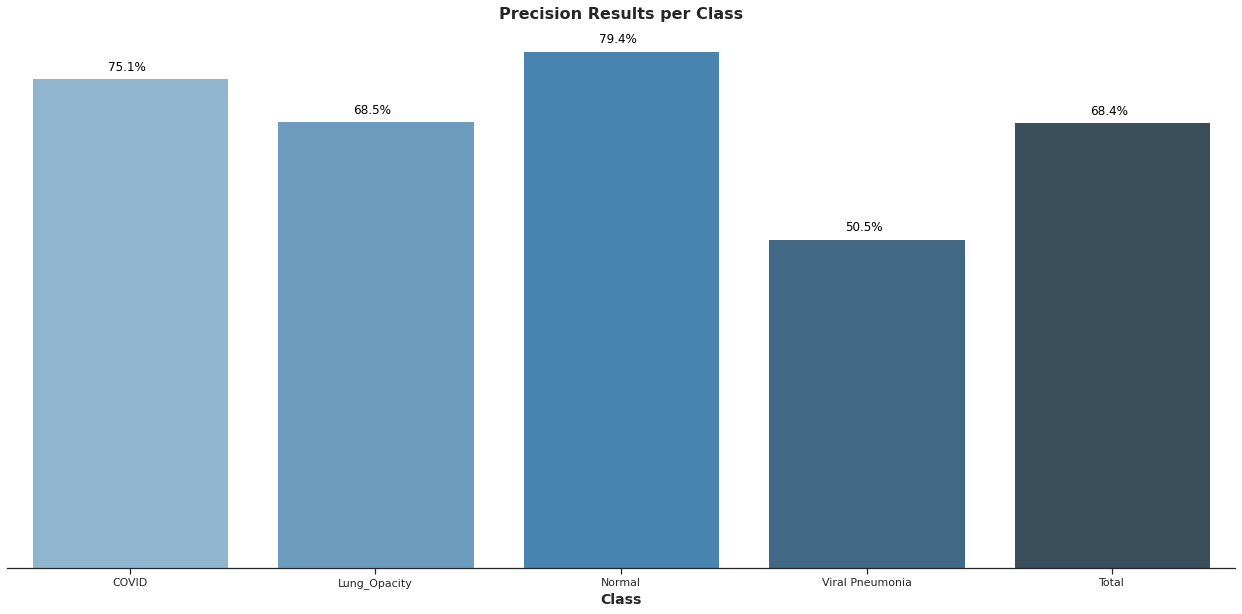

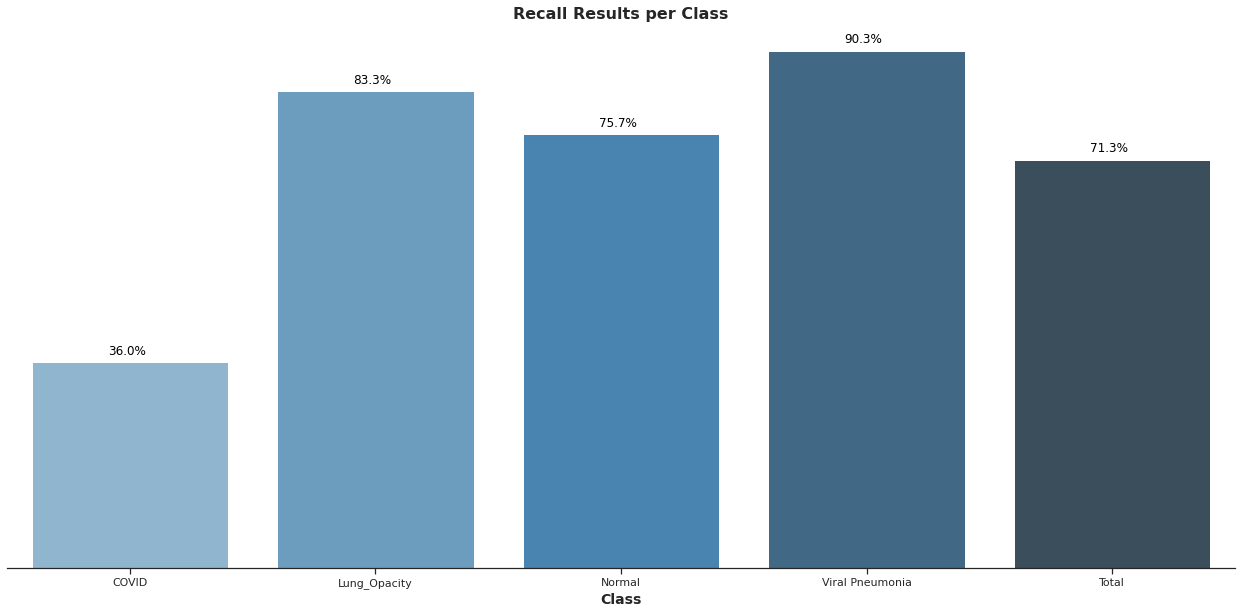

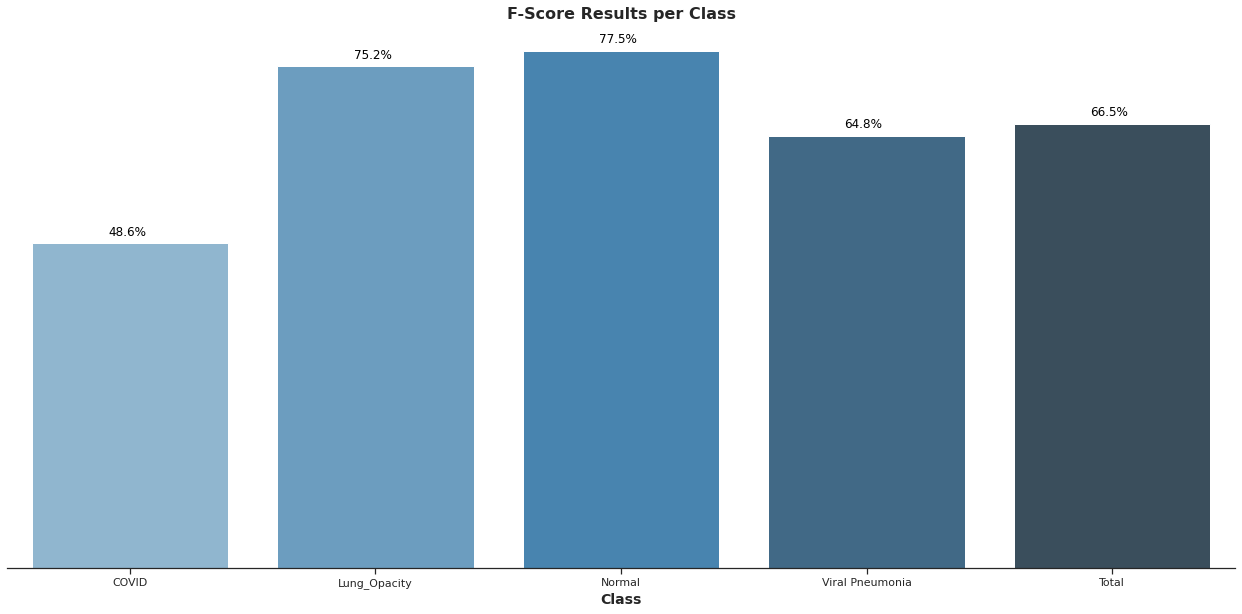

In [51]:
acc = accuracy_score(y_true, predictions)

results_all = precision_recall_fscore_support(y_true, predictions, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset